In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.env.dunderbot_env import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TODO:

- Add portfolio features (need to understand how to best format different types of observations in Box -- e.g., can I pad with 0:s/NaN:s?)
- Refactor current reward and add some new ones (RLTRAder resets reward, check it out)
- Add reward output
- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
- understand the rendering, especially during learning
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- setup train/test functionality (separate reset functions? Multiple time periods for testing?)
- Check/Enable/Add exploration noise
- Understand how we should format observations, both for MLP and LSTM policy networks
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type
- self.stationarize_rewards?


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage

# Run

In [3]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, total_timesteps=10000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




--------------------------------------
| approxkl           | 0.00020784535 |
| clipfrac           | 0.0           |
| explained_variance | 0.0438        |
| fps                | 108           |
| n_updates          | 1             |
| policy_entropy     | 2.1970067     |
| policy_loss        | -0.0030078671 |
| serial_timesteps   | 128           |
| time_elapsed       | 0.000312      |
| total_timesteps    | 128           |
| value_loss         | 1.8660772e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.00044474262 |
| clipfrac           | 0.0           |
| explained_variance | 0.363         |
| fps                | 129           |
| n_updates          | 10            |
| policy_entropy    

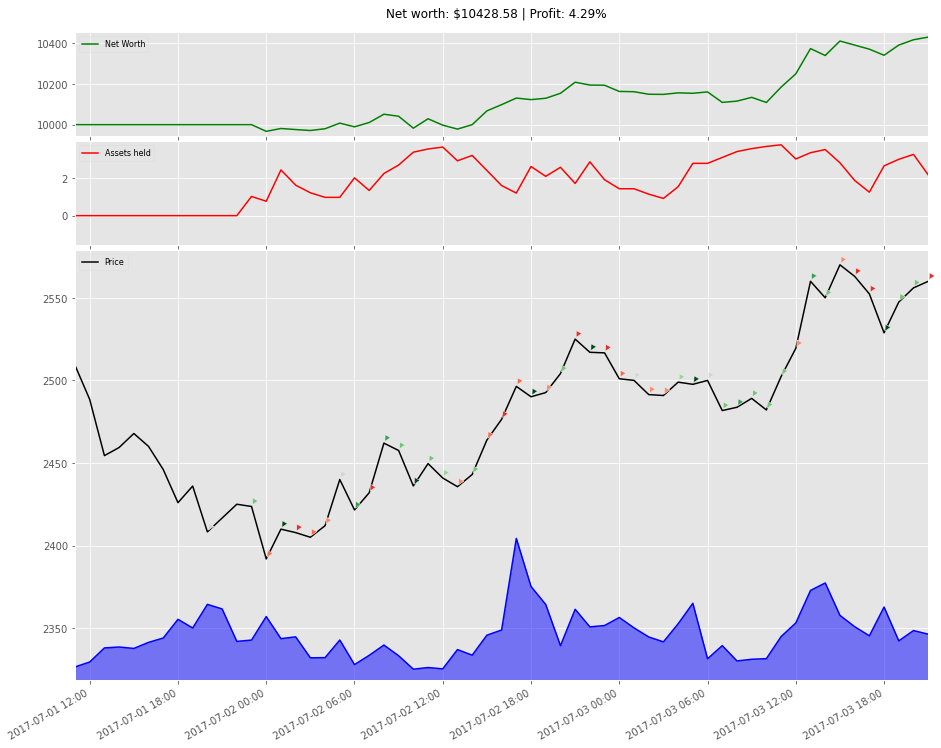

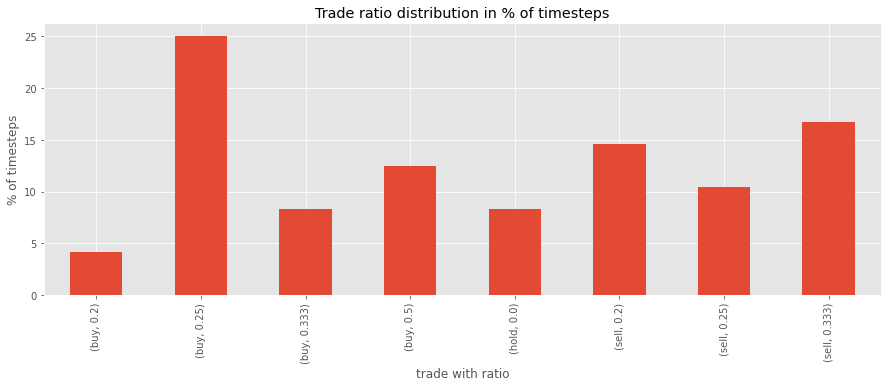

CPU times: user 3.48 s, sys: 136 ms, total: 3.61 s
Wall time: 3.62 s


In [4]:
%%time
run.predict(env=env, model=model, total_timesteps=50, rendermode='human')

In [8]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 59,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10017.32,
  10015.44,
  9986.24,
  9998.67,
  9997.23,
  9995.77,
  9998.19,
  10007.84,
  10001.48,
  10003.87,
  10009.4,
  10008.58,
  10005.95,
  10007.05,
  9988.86,
  9980.11,
  9988.3,
  9999.9,
  10003.39,
  10007.82,
  10007.12,
  10009.38,
  10017.58,
  10027.54,
  10024.68,
  10024.62,
  10021.82,
  10021.65,
  10020.12,
  10020.06,
  10020.43,
  10020.4,
  10020.43,
  10020.32,
  10020.33,
  10024.68,
  10021.84,
  10027.29,
  10030.74,
  10037.31,
  10036.02,
  10038.6,
  10037.88,
  10036.78,
  10016.29,
  10024.39,
  10026.88,
  10028.02],
 'trades': [{'step': 10,
   'amount': 2.06900547,
   'total': 5000.0,
   'type': 'buy',
   'action_amount': 0.5},
  {'step': 11,
   'amount': 0.68966849,
   'total': 1672.44,
   'type': 'sell',
   'action_amount': 0.3333333333333333},
  {'step': 12,
   'amount': 0.45977899,
   'to

In [9]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history'])

In [10]:
x['trades']

[{'step': 10,
  'amount': 2.06900547,
  'total': 5000.0,
  'type': 'buy',
  'action_amount': 0.5},
 {'step': 11,
  'amount': 0.68966849,
  'total': 1672.44,
  'type': 'sell',
  'action_amount': 0.3333333333333333},
 {'step': 12,
  'amount': 0.45977899,
  'total': 1114.33,
  'type': 'sell',
  'action_amount': 0.3333333333333333},
 {'step': 13,
  'amount': 0.2298895,
  'total': 549.87,
  'type': 'sell',
  'action_amount': 0.25},
 {'step': 14,
  'amount': None,
  'total': None,
  'type': 'hold',
  'action_amount': None},
 {'step': 15,
  'amount': 0.17241712,
  'total': 415.15,
  'type': 'sell',
  'action_amount': 0.25},
 {'step': 16,
  'amount': 0.17241712,
  'total': 414.66,
  'type': 'sell',
  'action_amount': 0.3333333333333333},
 {'step': 17,
  'amount': None,
  'total': None,
  'type': 'hold',
  'action_amount': None},
 {'step': 18,
  'amount': None,
  'total': None,
  'type': 'hold',
  'action_amount': None},
 {'step': 19,
  'amount': 0.11494475,
  'total': 278.34,
  'type': 'sell',

In [12]:
test = [123, 345]

[autoreload of src.env.dunderbot_env failed: Traceback (most recent call last):
  File "/root/.cache/pypoetry/virtualenvs/dunderbot-MATOk_fk-py3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/root/.cache/pypoetry/virtualenvs/dunderbot-MATOk_fk-py3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/code/src/env/dunderbot_env.py", line 12, in <module>
    from src.env.rewards import BaseRewardStrategy, Increme

In [13]:
test.pct_change()

AttributeError: 'list' object has no attribute 'pct_change'

In [15]:
import pandas as pd
pd.Series(test)

0    123
1    345
dtype: int64